In [1]:
# Importing GemPy
import gempy as gp

# Importing aux libraries
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from gempy.plot import visualization_2d as vv
from gempy.plot import vista

## Loading the xarray

We want to import the data from disk, where it is stored as a netCDF file.

In [2]:
import xarray as xr

In [3]:
fat_grid = xr.open_dataset('../data/fatiando_gridded_data.nc')
fat_grid

<xarray.Dataset>
Dimensions:           (easting: 95, northing: 157)
Coordinates:
    extra_coord       (northing, easting) float64 ...
  * northing          (northing) float64 4.175e+06 4.176e+06 ... 4.253e+06
  * easting           (easting) float64 -3.24e+05 -3.235e+05 ... -2.769e+05
Data variables:
    magnetic_anomaly  (northing, easting) float64 ...
Attributes:
    metadata:  Generated by EQLHarmonic(damping=1, relative_depth=1000)

## Initializating model

First we create a model to store things in.

In [4]:
geo_model = gp.create_model('From_Fatiando')

# We will create the regular grid afterwards
geo_model = gp.init_data(geo_model)

i:\pycharmprojects\gempy\gempy\gempy_api.py:177: UserWarning: Regular grid won't be initialize, you will have to create a gridafterwards. See gempy.set_grid
  warnings.warn('Regular grid won\'t be initialize, you will have to create a gridafterwards. See gempy.set_grid')


In [5]:
geo_model.add_surfaces(['mag_surface', 'basement'])

,surface,series,order_surfaces,color,id
0,mag_surface,Default series,1,#015482,1
1,basement,Default series,2,#9f0052,2


In [6]:
gp.set_interpolator(geo_model, theano_optimizer='fast_compile', verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                 values
range                0
$C_o$                0
drift equations    [3]


### Xarray to pandas

This seems to give something reasonably shaped.

Our next issue is to add points and surfaces. In theory, we can use each axis to create the points, but that will almost certainly be too many.

GemPy expects to be given a `DataFrame`, not a `Dataset`, so we will need to convert it. It also expects to find the columns `X|x`, `Y|y`, `Z|z` and one of `surface`, `Surface`, `surfaces`, `surfaces`, `formations`, or `formation`, which probably do not exist from harmonica by default.

Note: being able to set this might be nice if I am importing a cube of points.

In [7]:
df_fat_grid = fat_grid.to_dataframe()
df_fat_grid.reset_index(inplace=True)
new_columns = {'easting': 'X',
               'northing': 'Y',
              }
df_fat_grid.rename(columns=new_columns, inplace=True)
df_fat_grid['surface'] = 'mag_surface'

# Adding Z anisotropy
df_fat_grid['Z'] = df_fat_grid['magnetic_anomaly'] * 50

df_fat_grid

,X,Y,magnetic_anomaly,extra_coord,surface,Z
0,-324002.139135,4.175068e+06,30.667677,1500.0,mag_surface,1533.383839
1,-324002.139135,4.175568e+06,30.405465,1500.0,mag_surface,1520.273258
2,-324002.139135,4.176067e+06,30.265085,1500.0,mag_surface,1513.254228
3,-324002.139135,4.176567e+06,30.310932,1500.0,mag_surface,1515.546619
4,-324002.139135,4.177067e+06,30.669662,1500.0,mag_surface,1533.483114
...,...,...,...,...,...,...
14910,-276890.268483,4.251041e+06,172.457827,1500.0,mag_surface,8622.891370
14911,-276890.268483,4.251541e+06,168.851813,1500.0,mag_surface,8442.590645
14912,-276890.268483,4.252040e+06,163.476307,1500.0,mag_surface,8173.815338
14913,-276890.268483,4.252540e+06,156.952806,1500.0,mag_surface,7847.640282


### Decimating surface points

We need to decimate the data somehow, so that we have fewer points.

In [8]:
dec_df_fat_grid = df_fat_grid.iloc[::150].reset_index()

In [9]:
# Setting the df to gempy
geo_model.set_surface_points(dec_df_fat_grid, 
                             update_surfaces=False)

,X,Y,Z,smooth,surface
0,-324002.139135,4.175068e+06,1533.383839,0.000002,mag_surface
1,-324002.139135,4.250041e+06,-5365.022287,0.000002,mag_surface
2,-323500.949022,4.246542e+06,-5800.937793,0.000002,mag_surface
3,-322999.758908,4.243044e+06,-6190.410350,0.000002,mag_surface
4,-322498.568795,4.239545e+06,-6676.778121,0.000002,mag_surface
5,-321997.378682,4.236046e+06,-6792.256819,0.000002,mag_surface
6,-321496.188568,4.232547e+06,-7014.618490,0.000002,mag_surface
7,-320994.998455,4.229049e+06,-7342.856694,0.000002,mag_surface
8,-320493.808342,4.225550e+06,-7885.518557,0.000002,mag_surface
9,-319992.618229,4.222051e+06,-8713.366590,0.000002,mag_surface


#### Creating one orientation (minimum required)

The minimum amout of data for GemPy is:
- 2 surface points per surface
- 1 orientations per series

Note: I am not sure what happened with the error message about this. We need a patch

In [10]:
# Create a dummy orientation far away from the model 
geo_model.add_orientations(-323835.075764, 4.223884e+06, 36000.098226, pole_vector=(0,0,1), surface='mag_surface')

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,-323835.075764,4223884.0,36000.098226,0.0,0.0,1.0,0.01,mag_surface


## Adding grid around

The model needs some extents, in the format `[x_min, x_max, y_min, y_max, z_min, z_max]`.

We want to use the extents from the fatiando grid, which we can extract thus. The z coords are a little weird, so I am guessing them for now. This would presumably be how deep you expect your model to actually extend. For mag data, a couple of km seems reasonable for now, but we want to vertically exaggerate things, in this case by a factor of 50.

In [11]:
geo_model.set_regular_grid([geo_model.surface_points.df['X'].min(),
                           geo_model.surface_points.df['X'].max(),
                           geo_model.surface_points.df['Y'].min(),
                           geo_model.surface_points.df['Y'].max(),
                           geo_model.surface_points.df['Z'].min(),
                           geo_model.surface_points.df['Z'].max()], [50,50,50])

Active grids: ['regular']


Grid Object. Values: 
array([[-323531.02042857, 4175847.52246451,  -10716.19643323],
       [-323531.02042857, 4175847.52246451,  -10070.9529328 ],
       [-323531.02042857, 4175847.52246451,   -9425.70943236],
       ...,
       [-277361.38718943, 4252260.37192834,   19610.2480873 ],
       [-277361.38718943, 4252260.37192834,   20255.49158773],
       [-277361.38718943, 4252260.37192834,   20900.73508817]])

In [12]:
p3d = gp.plot_3d(geo_model)

In [13]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,mag_surface,Default series,1,False,False,True,True,#015482,NaN,NaN,NaN,1
1,basement,Default series,2,True,False,True,True,#9f0052,NaN,NaN,NaN,2


In [14]:
# The default value of the covariance is 0 because we didn't 
# have orientations when we use set_interpolator
geo_model.additional_data

values
Structure isLith                                                                              True
          isFault                                                                            False
          number faults                                                                          0
          number surfaces                                                                        1
          number series                                                                          1
          number surfaces per series                                                           [1]
          len surfaces surface_points                                                        [100]
          len series surface_points                                                          [100]
          len series orientations                                                              [1]
Options   dtype                                                                            float64
          output                                                                           geology
          theano_optimizer                                                            fast_compile
          device                                                                               cpu
          verbosity                                                                             []
Kriging   range                                                                                  0
          $C_o$                                                                                  0
          drift equations                                                                      [3]
Rescaling rescaling factor                                                                  155945
          centers                      [-300446.2038089973, 4214053.947196422, 12480.640021273604]

In [15]:
# To set the default values now that all data is in place
# we need to call the followin
geo_model.update_additional_data()
geo_model.update_to_interpolator()

Setting kriging parameters to their default values.


True

In [16]:
gp.compute_model(geo_model)


Lithology ids 
  [2. 2. 2. ... 1. 1. 1.] 

The above error seems to be from placing points outside the plotting area.

In [17]:
p3d = gp.plot_3d(geo_model, plotter_type='background')
# With this you can just move the points
p3d.toggle_live_updating()

True

It seems that the range is too large

In [18]:
# Range defines how close the parameters influence each other
geo_model.modify_kriging_parameters('range', 20000)

p3d.update_surfaces()

True

In [19]:
p3d.update_surfaces()

True

In [20]:
# Smooth controls how close the surface goes trough the points
geo_model.modify_surface_points(geo_model.surface_points.df.index, smooth=1000, plot_object=p3d)

,X,Y,Z,smooth,surface
0,-324002.139135,4.175068e+06,1533.383839,1000.0,mag_surface
1,-324002.139135,4.250041e+06,-5365.022287,1000.0,mag_surface
2,-323500.949022,4.246542e+06,-5800.937793,1000.0,mag_surface
3,-322999.758908,4.243044e+06,-6190.410350,1000.0,mag_surface
4,-322498.568795,4.239545e+06,-6676.778121,1000.0,mag_surface
5,-321997.378682,4.236046e+06,-6792.256819,1000.0,mag_surface
6,-321496.188568,4.232547e+06,-7014.618490,1000.0,mag_surface
7,-320994.998455,4.229049e+06,-7342.856694,1000.0,mag_surface
8,-320493.808342,4.225550e+06,-7885.518557,1000.0,mag_surface
9,-319992.618229,4.222051e+06,-8713.366590,1000.0,mag_surface


In [21]:
geo_model.orientations

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,-323835.075764,4223884.0,36000.098226,0.0,0.0,1.0,0.01,mag_surface


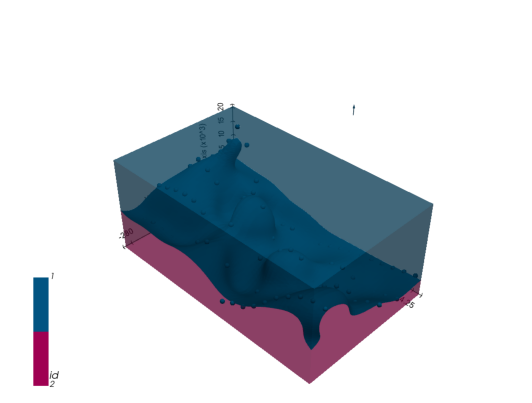

In [22]:
gp.plot_3d(geo_model, image=True)